# Non model based

In [47]:
import os
import re
import math
from copy import deepcopy
from itertools import chain
from string import punctuation
from operator import itemgetter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
here = os.getcwd()
project_path = os.path.dirname(here)
data_path = os.path.join(project_path, "data", "session_speech.csv")

In [49]:
data = pd.read_csv(data_path, converters={"speech":eval})
data.columns

Index(['name', 'vote', 'speech'], dtype='object')

In [50]:
data.shape

(70, 3)

In [51]:
data = data.explode(column="speech")
data.head()

,name,vote,speech
0,Ana Claudia Almirón,positivo,"Hace dos años, tuvimos una sesión histórica cu..."
1,Roberto Gustavo Basualdo,negativo,"Gracias, señor presidente. Hoy es un día en el..."
2,Pablo Daniel Blanco,negativo,Como voy a pedir la inserción de mis argumento...
3,Inés Imelda Blas,negativo,"Gracias, presidenta. Nuevamente, nos encontram..."
4,Néstor Braillard Poccard,negativo,"Gracias, señora presidenta. Realmente, como di..."


In [52]:
data.speech.isna().sum()

9

In [53]:
data.vote.isin(["abstención", "ausente"]).sum()

3

In [54]:
data[(data.speech.isna()) | (data.vote.isin(["abstención", "ausente"]))].shape

(11, 3)

In [55]:
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 3)

In [56]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(rf"[{punctuation}\“\”\¿\¡\−\…]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [57]:
data["speech_prep"] = data.speech.apply(preprocess)
data.head()

,name,vote,speech,speech_prep
0,Ana Claudia Almirón,positivo,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...
1,Roberto Gustavo Basualdo,negativo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...
2,Pablo Daniel Blanco,negativo,Como voy a pedir la inserción de mis argumento...,como voy a pedir la inserción de mis argumento...
3,Inés Imelda Blas,negativo,"Gracias, presidenta. Nuevamente, nos encontram...",gracias presidenta nuevamente nos encontramos ...
4,Néstor Braillard Poccard,negativo,"Gracias, señora presidenta. Realmente, como di...",gracias señora presidenta realmente como dijer...


## Difference of frequencies

In [58]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_prep)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,1,0,1,...,8,2,4,0,0,5,1,3,0,1
positivo,1,1,1,0,0,0,1,0,1,0,...,10,9,8,1,3,7,1,3,1,0


In [59]:
count_total = frequencies.sum(axis=0)
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0,1,1
1,abandonada,1,1,1,0
2,abandonadas,1,1,1,0
3,abandonar,1,-1,0,1
4,abandono,1,-1,0,1


## Difference of proportions

In [60]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000016,0.000019,0.000035
1,abandonada,1,0.000019,0.000019,0.000000
2,abandonadas,1,0.000019,0.000019,0.000000
3,abandonar,1,-0.000035,0.000000,0.000035
4,abandono,1,-0.000035,0.000000,0.000035


## Correction: removing stop words

In [61]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
stw = stopwords.words("spanish")
print(stw)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [63]:
len(stw)

313

In [64]:
stw = list(filter(lambda x: x in frequencies.columns,stw))
len(stw)

192

In [65]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(stw)))

In [66]:
len(frequencies.columns)

8050

In [67]:
frequencies_wo_stw = frequencies[columns_wo_stw]
len(frequencies_wo_stw.columns)

7858

In [68]:
frequencies_wo_stw

,abajo,abandonada,abandonadas,abandonar,abandono,abarca,abdominales,aberración,aberrante,aberrantes,...,último,últimos,única,únicamente,únicas,único,únicos,útero,úteros,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,1,0,1,...,8,2,4,0,0,5,1,3,0,1
positivo,1,1,1,0,0,0,1,0,1,0,...,10,9,8,1,3,7,1,3,1,0


In [69]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.000032,0.000038,0.00007
1,abandonada,1,0.000038,0.000038,0.00000
2,abandonadas,1,0.000038,0.000038,0.00000
3,abandonar,1,-0.000070,0.000000,0.00007
4,abandono,1,-0.000070,0.000000,0.00007


## Odds

In [70]:
odds_pos = proportions.loc["positivo"]/(1-proportions.loc["positivo"])
odds_neg = proportions.loc["negativo"]/(1-proportions.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,0.539367,0.000019,0.000035
1,abandonada,1,inf,0.000019,0.000000
2,abandonadas,1,inf,0.000019,0.000000
3,abandonar,1,0.000000,0.000000,0.000035
4,abandono,1,0.000000,0.000000,0.000035


In [71]:
odds_diff["diff"].isin([math.inf, -math.inf]).sum()

3588

In [72]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg) in infs:
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [73]:
odds_diff["diff"] = odds_diff.apply(lambda x: postprocess_odds(x), axis=1)
odds_diff

,word,total,diff,pos,neg
0,abajo,2,0.539367,0.000019,0.000035
1,abandonada,1,inf,0.000019,0.000000
2,abandonadas,1,inf,0.000019,0.000000
3,abandonar,1,0.000000,0.000000,0.000035
4,abandono,1,0.000000,0.000000,0.000035
...,...,...,...,...,...
8045,único,12,0.755094,0.000131,0.000173
8046,únicos,2,0.539367,0.000019,0.000035
8047,útero,6,0.539350,0.000056,0.000104
8048,úteros,1,inf,0.000019,0.000000


## Log-odds-ratio

In [74]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

/home/macarena/.pyenv/versions/3.11.4/envs/eddc-tp/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,word,total,diff,pos,neg
0,abajo,2,-0.617358,0.000019,0.000035
1,abandonada,1,inf,0.000019,0.000000
2,abandonadas,1,inf,0.000019,0.000000
3,abandonar,1,-inf,0.000000,0.000035
4,abandono,1,-inf,0.000000,0.000035


### Log-odds ratio suvizado

Agregar suavizado, pero cuidado: no se puede agregar peso sin más a una frecuencia (la suma ya no va a dar 1).

$$\widetilde{f}^{(i)} = f^{(i)} + \varepsilon$$

In [75]:
smooth_log_odds_diff = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
smooth_log_odds_diff.head()

,word,total,pos,neg
0,abajo,2,0.000019,0.000035
1,abandonada,1,0.000019,0.000000
2,abandonadas,1,0.000019,0.000000
3,abandonar,1,0.000000,0.000035
4,abandono,1,0.000000,0.000035


In [76]:
# cantidad de palabras con frecuencia 0
(smooth_log_odds_diff[["pos", "neg"]]==0).sum(axis=0)

pos    1913
neg    3588
dtype: int64

In [77]:
smooth_log_odds_diff[["f_pos", "f_neg"]] = smooth_log_odds_diff[["pos", "neg"]].applymap(
    lambda x: x+0.5 if x == 0 else x
)
smooth_log_odds_diff.head()

,word,total,pos,neg,f_pos,f_neg
0,abajo,2,0.000019,0.000035,0.000019,0.000035
1,abandonada,1,0.000019,0.000000,0.000019,0.500000
2,abandonadas,1,0.000019,0.000000,0.000019,0.500000
3,abandonar,1,0.000000,0.000035,0.500000,0.000035
4,abandono,1,0.000000,0.000035,0.500000,0.000035


In [78]:
f_smooth_odds_pos = smooth_log_odds_diff["f_pos"]/(1-smooth_log_odds_diff["f_pos"])
f_smooth_odds_neg = smooth_log_odds_diff["f_neg"]/(1-smooth_log_odds_diff["f_neg"])
f_smooth_odds_difference = f_smooth_odds_pos/f_smooth_odds_neg
f_smooth_log_odds_diff = (
    pd
    .DataFrame({
        "word": smooth_log_odds_diff.word,
        "total": smooth_log_odds_diff.total,
        "diff": np.log(f_smooth_odds_difference),
        "pos": f_smooth_odds_pos,
        "neg": f_smooth_odds_pos
    })
)
f_smooth_log_odds_diff.head()

,word,total,diff,pos,neg
0,abajo,2,-0.617358,0.000019,0.000019
1,abandonada,1,-10.887362,0.000019,0.000019
2,abandonadas,1,-10.887362,0.000019,0.000019
3,abandonar,1,10.270004,1.000000,1.000000
4,abandono,1,10.270004,1.000000,1.000000


## Correction: elimating low-frequency words

In [79]:
(
    pd.melt(
        proportions_diff[["word","pos","neg"]],
        id_vars=["word"],
        value_vars=["pos", "neg"],
    )
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

,min,q5,median,mean,std,q95,max
variable,,,,,,,
neg,0.0,0.0,0.000035,0.000124,0.001215,0.000277,0.057460
pos,0.0,0.0,0.000019,0.000124,0.001219,0.000299,0.057742


In [80]:
low_freq_df = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
low_freq_df.shape

(8050, 4)

In [81]:
low_freq_df = low_freq_df[(0.000035<low_freq_df["neg"]) & (0.000019<low_freq_df["pos"])]
low_freq_df.shape

(1361, 4)

In [82]:
low_freq_df[["pos", "neg"]].describe()

,pos,neg
count,1361.000000,1361.000000
mean,0.000614,0.000631
std,0.002915,0.002903
min,0.000037,0.000069
25%,0.000075,0.000104
50%,0.000131,0.000173
75%,0.000336,0.000347
max,0.057742,0.057460


In [83]:
high_freq_odds_pos = low_freq_df["pos"]/(1-low_freq_df["pos"])
high_freq_odds_neg = low_freq_df["neg"]/(1-low_freq_df["neg"])
high_freq_odds_difference = high_freq_odds_pos/high_freq_odds_neg
high_freq_log_odds_diff = (
    pd
    .DataFrame({
        "word": low_freq_df.word,
        "total": low_freq_df.total,
        "diff": np.log(high_freq_odds_difference),
        "pos": high_freq_odds_pos,
        "neg": high_freq_odds_neg
    })
    .reset_index(drop=True)
)
high_freq_log_odds_diff.head()

,word,total,diff,pos,neg
0,abortar,42,1.948232,0.000730,0.000104
1,aborto,287,0.199298,0.003734,0.003059
2,abortos,80,1.329531,0.001310,0.000347
3,absoluta,9,0.075813,0.000112,0.000104
4,absolutamente,49,0.508945,0.000692,0.000416


In [84]:
perc = round(high_freq_log_odds_diff.shape[0] / proportions_diff.shape[0] * 100, 2)
print(f"Se persisten el {perc}% de los datos.")

Se persisten el 16.91% de los datos.


## TF-IDF

In [85]:
discourses = list(map(lambda x: set(x.split()),data.speech_prep.tolist()))
words = sorted(list(set(chain(*discourses))))

X = np.zeros((len(discourses), len(words)))

for i in range(len(words)):
    for j in range(len(discourses)):
        if words[i] in discourses[j]:
            X[j,i] += 1


In [86]:
df = (
    pd.DataFrame(X, columns=words)
    .filter(frequencies.columns)
    .sum(axis=0)
    .to_frame()
    .rename(columns={0:"df"})
    .assign(
        idf=lambda x: 1/x,
        ln_idf=lambda x: x.idf.apply(lambda z: math.log(z))
    )
    .reset_index(names="word")
)
df.head()


,word,df,idf,ln_idf
0,abajo,2.0,0.5,-0.693147
1,abandonada,1.0,1.0,0.000000
2,abandonadas,1.0,1.0,0.000000
3,abandonar,1.0,1.0,0.000000
4,abandono,1.0,1.0,0.000000


In [87]:
# al final uso df sin ln porque muchas palabras ocurren solo en un documento y eso
# hace que su peso termine siendo 0
tf_idf = (
    proportions
    .T
    .rename_axis("", axis=1)
    .reset_index(names="word")
    .merge(df, on="word")
    .assign(
        pos=lambda x: x.positivo/(x.df),
        neg=lambda x: x.negativo/(x.df)
    )
)
tf_idf.head()

,word,negativo,positivo,df,idf,ln_idf,pos,neg
0,abajo,0.000035,0.000019,2.0,0.5,-0.693147,0.000009,0.000017
1,abandonada,0.000000,0.000019,1.0,1.0,0.000000,0.000019,0.000000
2,abandonadas,0.000000,0.000019,1.0,1.0,0.000000,0.000019,0.000000
3,abandonar,0.000035,0.000000,1.0,1.0,0.000000,0.000000,0.000035
4,abandono,0.000035,0.000000,1.0,1.0,0.000000,0.000000,0.000035


In [88]:
tfidf_diff = (
    pd
    .DataFrame({
        "word": tf_idf["word"],
        "diff": tf_idf["pos"]-tf_idf["neg"],
        "pos": tf_idf["pos"],
        "neg": tf_idf["neg"]
    })
    .merge(count_diff[["word", "total"]], on="word")
)
tfidf_diff.head()

,word,diff,pos,neg,total
0,abajo,-0.000008,0.000009,0.000017,2
1,abandonada,0.000019,0.000019,0.000000,1
2,abandonadas,0.000019,0.000019,0.000000,1
3,abandonar,-0.000035,0.000000,0.000035,1
4,abandono,-0.000035,0.000000,0.000035,1


In [89]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 0.34


## WordScores

In [90]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0) / frequencies.sum().sum()

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw,
        "wnkw": wkw*nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

,word,total,diff,wkw,nkw,wnkw
0,abajo,2,-0.000007,-0.299228,0.000024,-0.000007
1,abandonada,1,0.000012,1.000000,0.000012,0.000012
2,abandonadas,1,0.000012,1.000000,0.000012,0.000012
3,abandonar,1,-0.000012,-1.000000,0.000012,-0.000012
4,abandono,1,-0.000012,-1.000000,0.000012,-0.000012


In [91]:
corr_prop = wkw_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

Correlación con proporciones: 0.99


## Visualizations

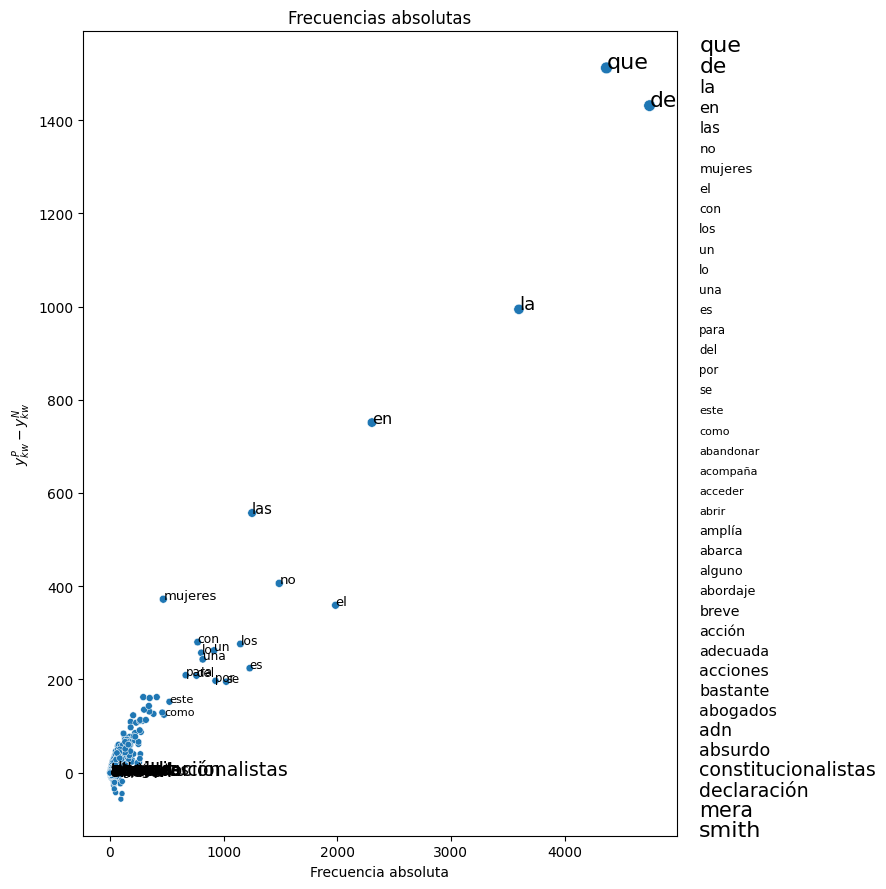

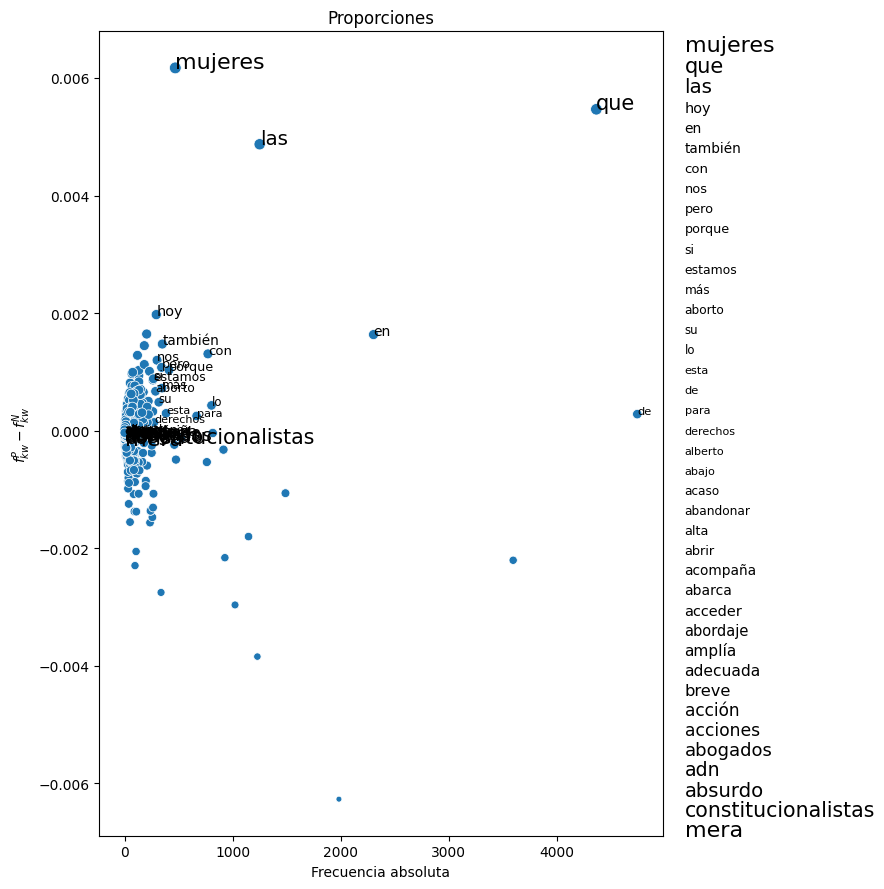

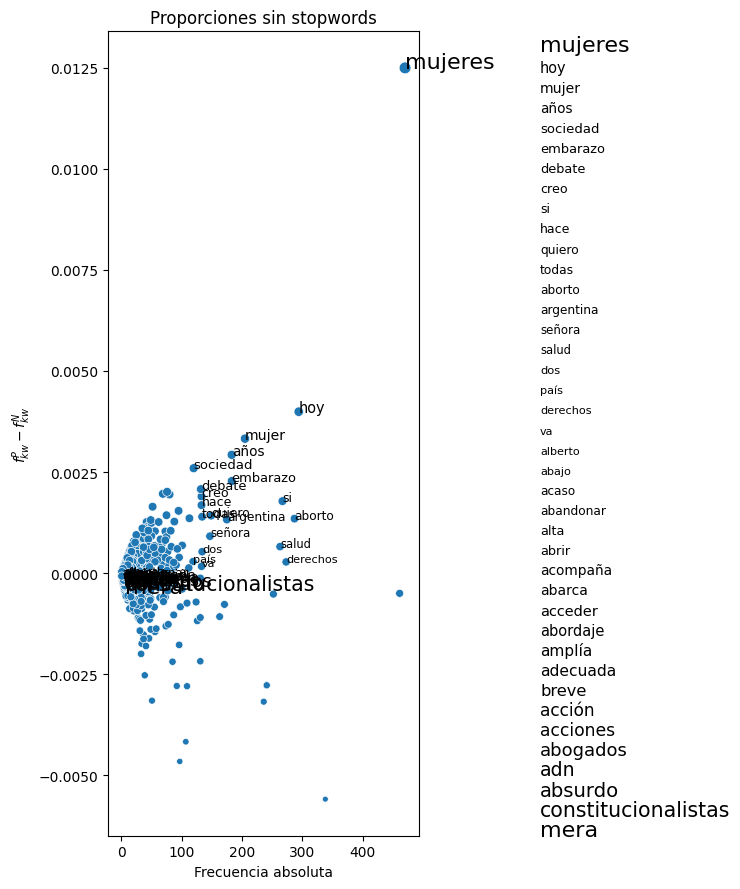

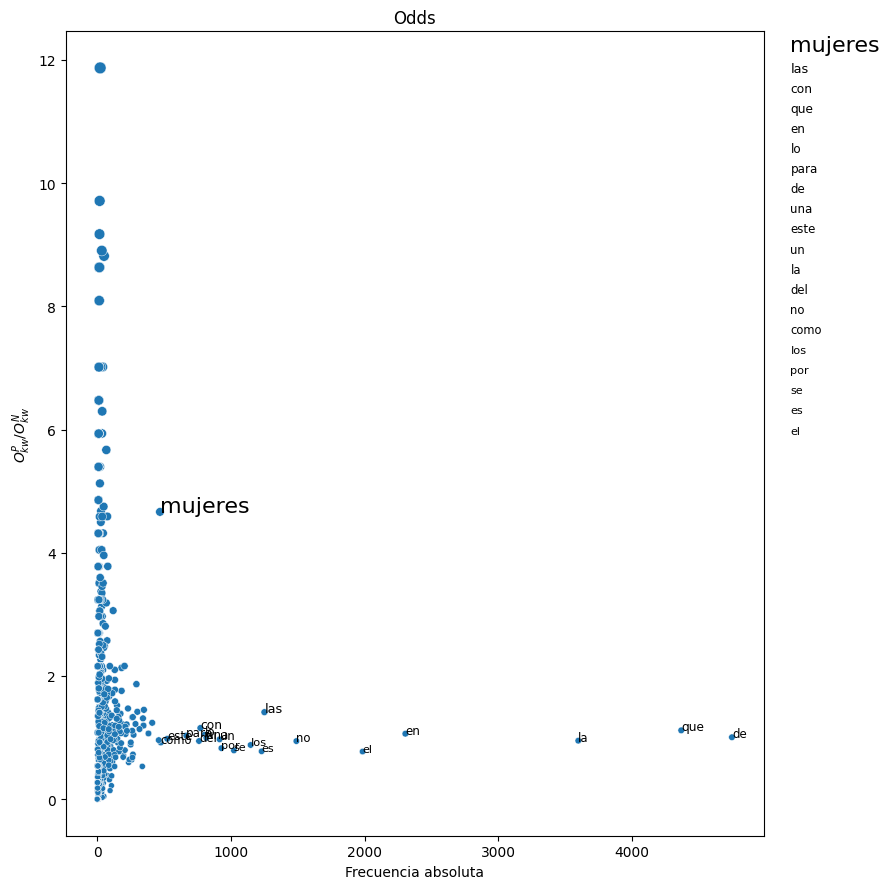

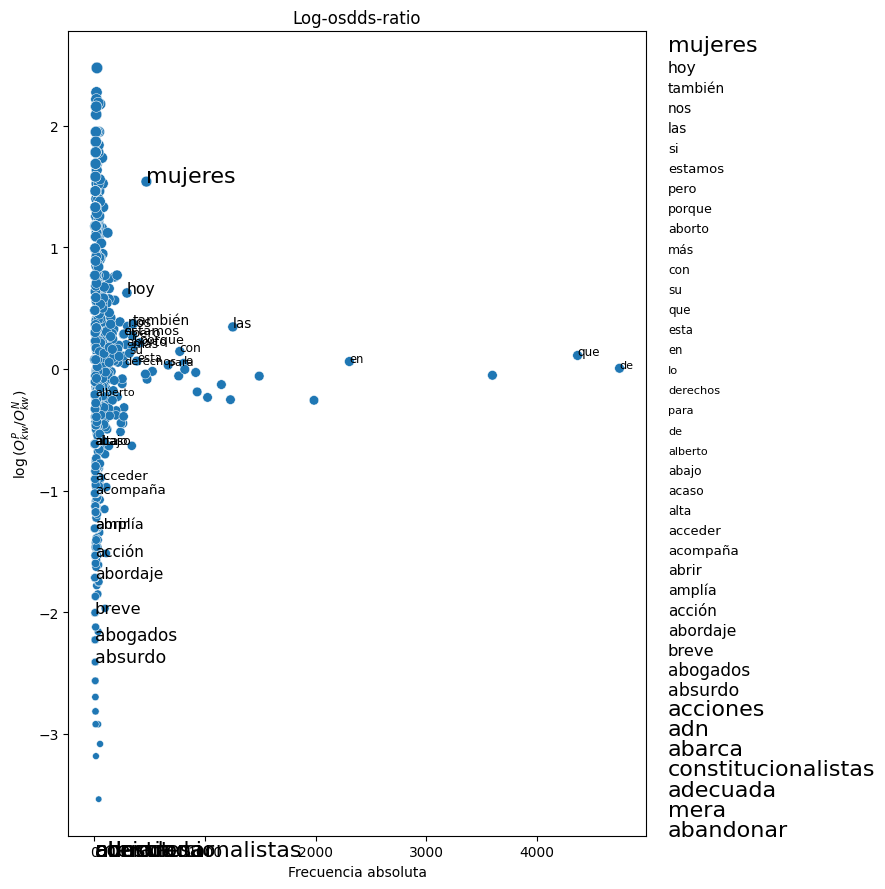

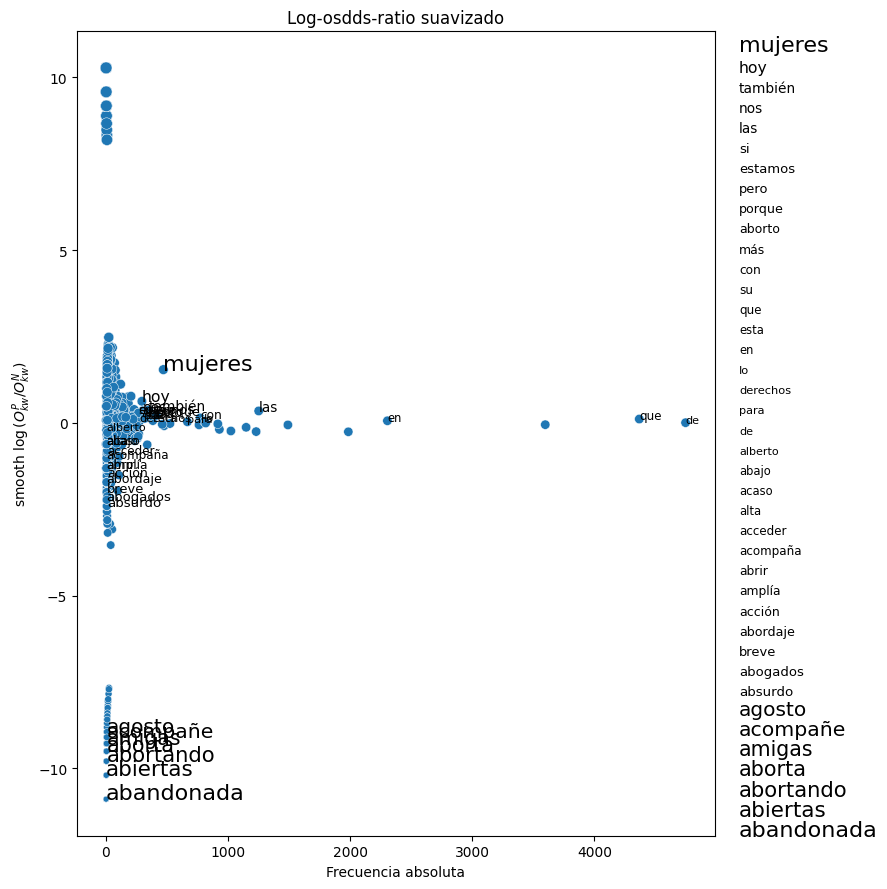

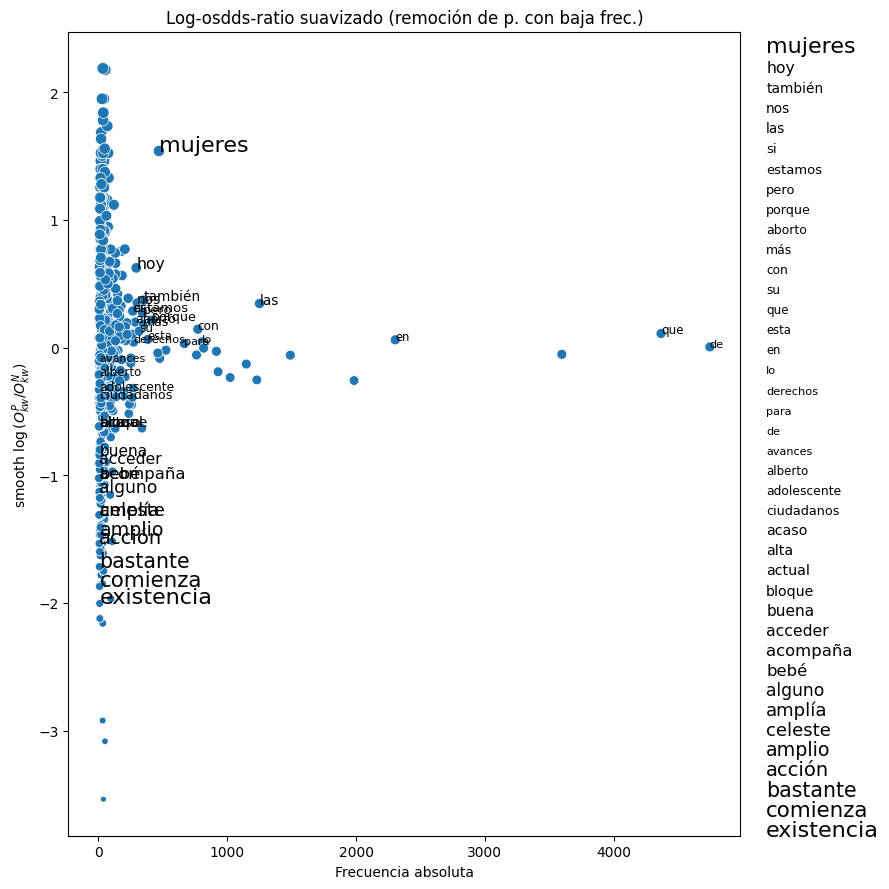

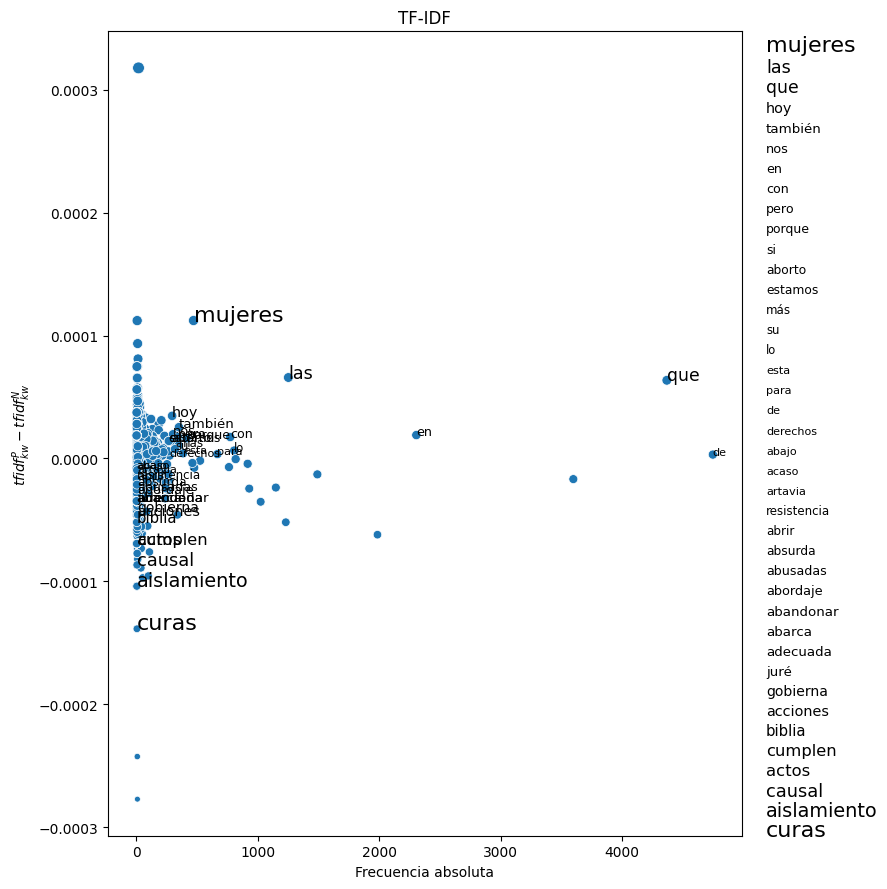

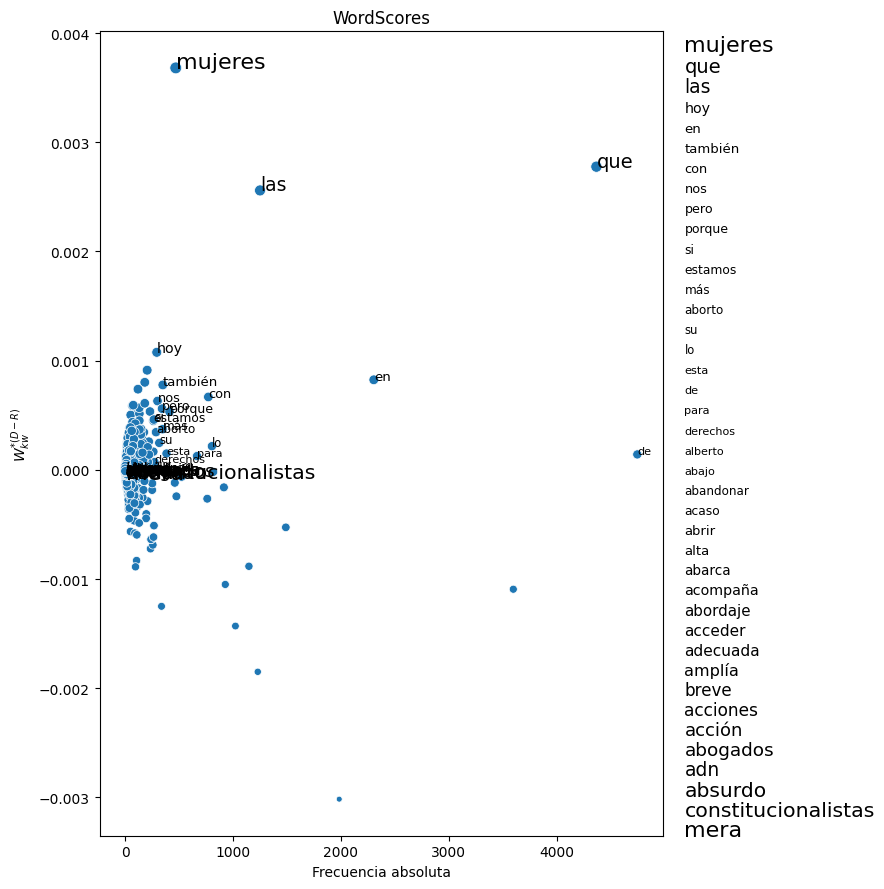

In [92]:
stats = [
    count_diff, proportions_diff, proportions_wo_stw_diff, odds_diff,
    log_odds_diff, f_smooth_log_odds_diff, high_freq_log_odds_diff,
    tfidf_diff, wkw_diff
]
titles = [
    "Frecuencias absolutas", "Proporciones", "Proporciones sin stopwords", "Odds",
    "Log-osdds-ratio", "Log-osdds-ratio suavizado",
    "Log-osdds-ratio suavizado (remoción de p. con baja frec.)",
    "TF-IDF", "WordScores"
]
y_labels = [
    "$y^{P}_{kw}-y^{N}_{kw}$", "$f^{P}_{kw}-f^{N}_{kw}$", "$f^{P}_{kw}-f^{N}_{kw}$",
    "$O^{P}_{kw}/O^{N}_{kw}$", "$\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$", "$tfidf^{P}_{kw}-tfidf^{N}_{kw}$",
    "$W^{*(D-R)}_{kw}$"
]
for df, title, y_label in zip(stats,titles,y_labels):
    fig, ax = plt.subplots(figsize=(9,9))
    df_copy = deepcopy(df)
    _max = df_copy["diff"].sort_values().unique().tolist()[-2]
    _min = df_copy["diff"].sort_values().unique().tolist()[2]
    df_copy["size"] = df_copy["diff"].apply(
        lambda x: math.ceil(_max)
        if x==math.inf
        else x
    )
    df_copy["size"] = df_copy["size"].apply(
        lambda x: math.floor(_min)
        if x==-math.inf
        else x
    )
    size_scaler = MinMaxScaler(feature_range=(0.001,1.0))
    dot_size = size_scaler.fit_transform(np.array(df_copy["size"]).reshape(-1,1)).reshape(len(df_copy))
    sns.scatterplot(df_copy, x="total", y="diff", size=dot_size, ax=ax)
    pos = df_copy[df_copy["size"]>0]
    neg = df_copy[df_copy["size"]<0]
    words_scaler = MinMaxScaler(feature_range=(8.0,16.0))
    data = list()
    if not pos.empty:
        pos = (
            pos
            .nlargest(n=20, columns=["total", "size"], keep="first")
            .assign(
                text_size=lambda x: words_scaler.fit_transform(np.array(x["size"]).reshape(-1,1))
            )
            .sort_values(by=["size", "text_size"], ascending=False)
        )
        data.append(pos)
    if not neg.empty:
        neg = (
            neg
            .drop_duplicates(subset=["total", "size"], keep="first")
            .nsmallest(n=20, columns=["total", "size"], keep="first")
            .assign(
                text_size=lambda x: words_scaler.fit_transform(np.array(x["size"]*-1).reshape(-1,1))
            )
            .sort_values(by=["size"], ascending=False)
        )
        data.append(neg)
    words = pd.concat(data)
    for e, (i, row) in enumerate(words.iterrows(), start=1):
        ax.text(
            row["total"], row["size"], row["word"],
            horizontalalignment='left', color='black', fontsize=row["text_size"]
        )
        ylim_min, ylim_max = ax.get_ylim()
        ylim_div = (ylim_max-ylim_min)/40
        ax.text(
            ax.get_xlim()[1]+200, ylim_max-(e*ylim_div), row["word"],
            horizontalalignment='left', color='black', fontsize=row["text_size"]
        )
    ax.set_title(title)
    ax.set_xlabel("Frecuencia absoluta")
    ax.set_ylabel(y_label)
    ax.get_legend().set_visible(False)
    plt.tight_layout()
    filename = title.lower().replace(" ", "_")
    plt.savefig(f"{project_path}/visualizations/stats__{filename}.png")


Ideas:
- en esta nb, hacer las visualizaciones propuestas por el paper para todos los casos
- en la nb de clasificación voy a necesitar features, puedo elegir alguna de estas técnicas visualizando con 
- 

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando